# COVID19 - Brazil States

Install necessary packages for parallel computation:

```
pip install ipyparallel
ipcluster nbextension enable
pip install parallel-execute
```

To install for all users on JupyterHub, as root:
```
jupyter nbextension install --sys-prefix --py ipyparallel
jupyter nbextension enable --sys-prefix --py ipyparallel
jupyter serverextension enable --sys-prefix --py ipyparallel
```

start cluster at jupyter notebook interface

In [1]:
import urllib.request
import pandas as pd
import numpy as np

In [2]:
# Download data
import get_data
LoadData=True

if LoadData:
    get_data.get_data()

Baixando arquivos brasil.io...


In [3]:
df = pd.read_csv("data/dados_total_estados.csv")
df

,index,date,state,city,place_type,confirmed,deaths,order_for_place,is_last,popEst,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
0,0,2020-06-04,SE,TOTAL,state,8200,186,72,True,2298696.0,28.0,356.72399,0.0227
1,1,2020-06-03,SE,TOTAL,state,7989,180,71,False,2298696.0,28.0,347.54487,0.0225
2,2,2020-06-02,SE,TOTAL,state,7555,172,70,False,2298696.0,28.0,328.66460,0.0228
3,3,2020-06-01,SE,TOTAL,state,7233,166,69,False,2298696.0,28.0,314.65666,0.0230
4,4,2020-05-31,SE,TOTAL,state,6999,158,68,False,2298696.0,28.0,304.47697,0.0226
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,157350,2020-03-13,AL,TOTAL,state,1,0,5,False,3337357.0,27.0,0.02996,0.0000
2188,157351,2020-03-12,AL,TOTAL,state,1,0,4,False,3337357.0,27.0,0.02996,0.0000
2189,157352,2020-03-10,AL,TOTAL,state,1,0,3,False,3337357.0,27.0,0.02996,0.0000
2190,157353,2020-03-09,AL,TOTAL,state,1,0,2,False,3337357.0,27.0,0.02996,0.0000


In [4]:
# Model

In [5]:
# states=['SP','ES','MG','RJ','PE','CE','AM']
states=['SP','MG','ES']
states

['SP', 'MG', 'ES']

'# SEAIR-D Model Equations

$$\begin{array}{l}\frac{d s}{d t}=-[\beta i(t) + \beta_2 a(t)-\mu] \cdot s(t)\\ 
\frac{d e}{d t}=[\beta i(t) + \beta_2 a(t)] \cdot s(t) -(\sigma+\mu) \cdot e(t)\\ 
\frac{d a}{d t}=\sigma e(t) \cdot (1-p)-(\gamma+\mu) \cdot a(t) \\
\frac{d i}{d t}=\sigma e(t) \cdot p - (\gamma + \sigma_2 + \sigma_3 + \mu) \cdot i(t)\\ 
\frac{d r}{d t}=(b + \sigma_2) \cdot i(t) + \gamma \cdot a(t) - \mu \cdot r(t)\\
\frac{d k}{d t}=(a + \sigma_3 - \mu) \cdot d(t)
\end{array}$$

The last equation does not need to be solve because:

$$\frac{d k}{d t}=-(\frac{d e}{d t}+\frac{d a}{d t}+\frac{d i}{d t}+\frac{d r}{d t})$$

The sum of all rates are equal to zero! The importance of this equation is that it conservates the rates.


## Parameters

$\beta$: Effective contact rate [1/min]
    
$\gamma$: Recovery(+Mortality) rate $\gamma=(a+b)$ [1/min]

$a$: mortality of healed  [1/min]

$b$: recovery rate  [1/min]

$\sigma$: is the rate at which individuals move from the exposed to the infectious classes. Its reciprocal ($1/\sigma$) is the average latent (exposed) period.

$\sigma_2$: is the rate at which individuals move from the infectious to the healed classes. Its reciprocal ($1/\sigma_2$) is the average latent (exposed) period

$\sigma_3$: is the rate at which individuals move from the infectious to the dead classes. Its reciprocal ($1/\sigma_3$) is the average latent (exposed) period
    
$p$: is the fraction of the exposed which become symptomatic infectious sub-population.

$(1-p)$: is the fraction of the exposed which becomes asymptomatic infectious sub-population.

In [6]:
# Initial parameters
dfparam = pd.read_csv("data/param.csv")
dfparam = dfparam.dropna()
dfparam

,state,start-date,prediction-range,s0,e0,a0,i0,r0,d0,START,RATIO,WCASES,WREC
0,SP,2020-03-20,200,13000000.0,0.0001,0.0001,800,300,800,100,0.15,0.55,0.01
1,ES,2020-04-01,200,380000.0,0.0001,0.0001,50,10,100,100,0.10,0.65,0.00
2,MG,2020-04-01,200,700000.0,0.0001,0.0001,100,100,50,100,0.05,0.55,0.01
3,RJ,2020-03-20,200,700000.0,0.0001,0.0001,800,300,400,100,0.15,0.50,0.01
4,CE,2020-03-20,200,700000.0,0.0001,0.0001,800,300,400,100,0.15,0.50,0.01
5,PE,2020-03-20,200,700000.0,0.0001,0.0001,800,300,400,100,0.15,0.50,0.01
6,AM,2020-03-20,200,700000.0,0.0001,0.0001,800,300,400,100,0.15,0.50,0.01


In [7]:
# Initial parameter optimization

In [8]:
import ray
ncpu=len(states)
ray.init(num_cpus=ncpu)

# Load solver
GlobalOptimization = False
Yabox = True

if GlobalOptimization:
    import LearnerGlobalOpt as Learner  # basinhopping global optimization (several times minimize)
elif Yabox:
    import LearnerYabox as Learner #Yabox
else:
    import Learner as Learner #minimize

2020-06-05 21:32:59,922	INFO resource_spec.py:205 -- Starting Ray with 32.37 GiB memory available for workers and up to 16.21 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-06-05 21:33:00,790	INFO resource_spec.py:205 -- Starting Ray with 32.37 GiB memory available for workers and up to 16.2 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


In [9]:
allStates=True
cleanRecovered=False
version="1"

results=[]
if allStates:
    for state in states:        
        query = dfparam.query('state == "{}"'.format(state)).reset_index()
        parameters = np.array(query.iloc[:, 2:])[0]
        parameters
        learner = Learner.Learner.remote(state, *parameters, cleanRecovered, version)
        #learner.train()
        #add function evaluation to the queue
        results.append(learner.train.remote())
else:
    state= "ES"
    query = dfparam.query('state == "{}"'.format(state)).reset_index()
    parameters = np.array(query.iloc[:, 2:])[0]
    parameters
    cleanRecovered = False
    learner = Learner.Learner.remote(state, *parameters, cleanRecovered, version)
    #learner.train()
    #add function evaluation to the queue
    results.append(learner.train.remote())

# #execute all the queue with max_runner_cap at a time    
results = ray.get(results)

:26, 7078.88it/s]
100%|█████████▉| 1999000/2000000 [11:36<00:00, 9389.95it/s]


In [10]:
ray.shutdown()

100%|█████████▉| 1999000/2000000 [11:36<00:00, 2869.89it/s]


# Plots

In [11]:
%matplotlib inline 
import matplotlib.pyplot as plt
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2
import covid_plots

In [12]:
def loadDataFrame(filename):
    df= pd.read_pickle(filename)
    df.columns = [c.lower().replace(' ', '_') for c in df.columns]
    df.columns = [c.lower().replace('(', '') for c in df.columns]
    df.columns = [c.lower().replace(')', '') for c in df.columns]
    return df

In [13]:
selectedState='RJ'

#select districts for plotting log plot
states4Plot=['MG',
               'SP',
               'ES',
               'CE',
               selectedState]

#Choose here your options
#opt=0 all plots
#opt=1 corona log plot
#opt=2 logistic model prediction
#opt=3 bar plot with growth rate
#opt=4 log plot + bar plot
#opt=5 SEAIR-D Model
opt = 5

#versio'n to identify the png file result
# version = "1"

#parameters for plotting
query = dfparam.query('state == "{}"'.format(state)).reset_index()
startdate = query['start-date'][0]
predict_range = query['prediction-range'][0]
ratio = query['RATIO'][0]

#number of cases to start plotting model in log graph - real data = 100
startCase=100

In [14]:
#do not allow the scrolling of the plots

In [15]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;}

<IPython.core.display.Javascript object>

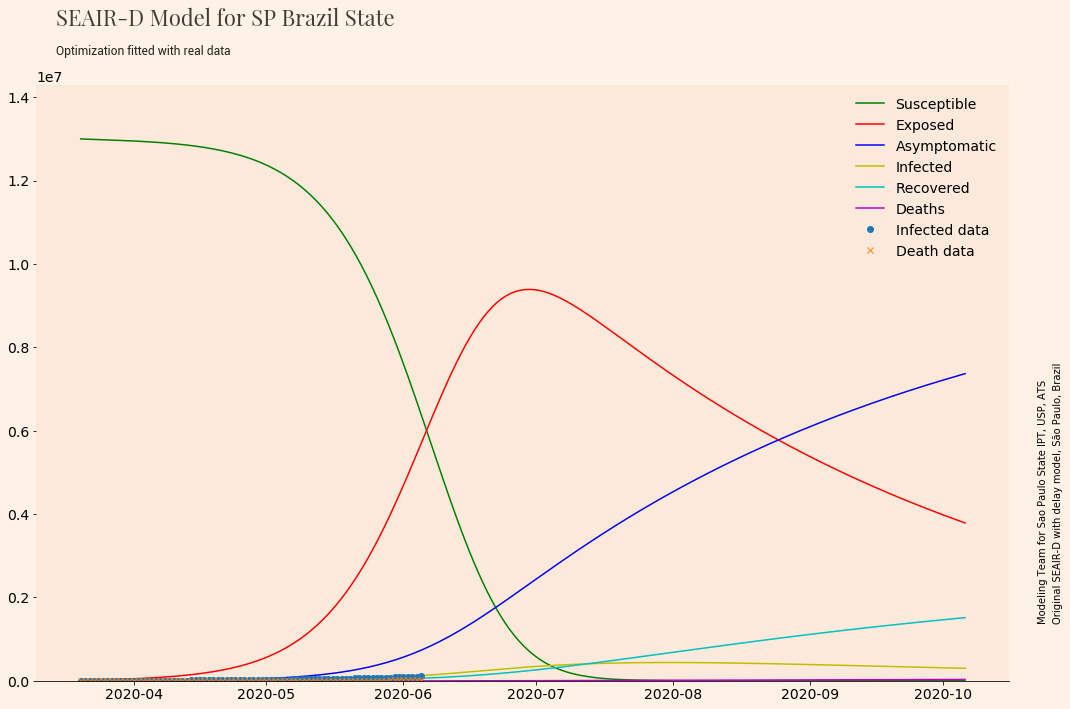

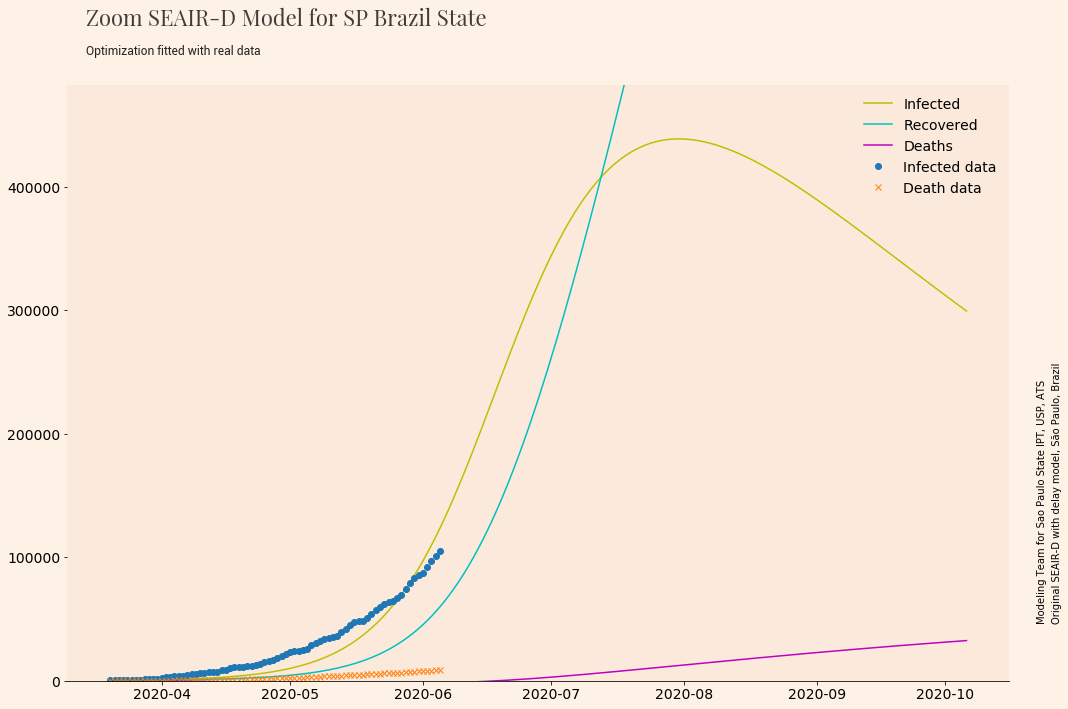

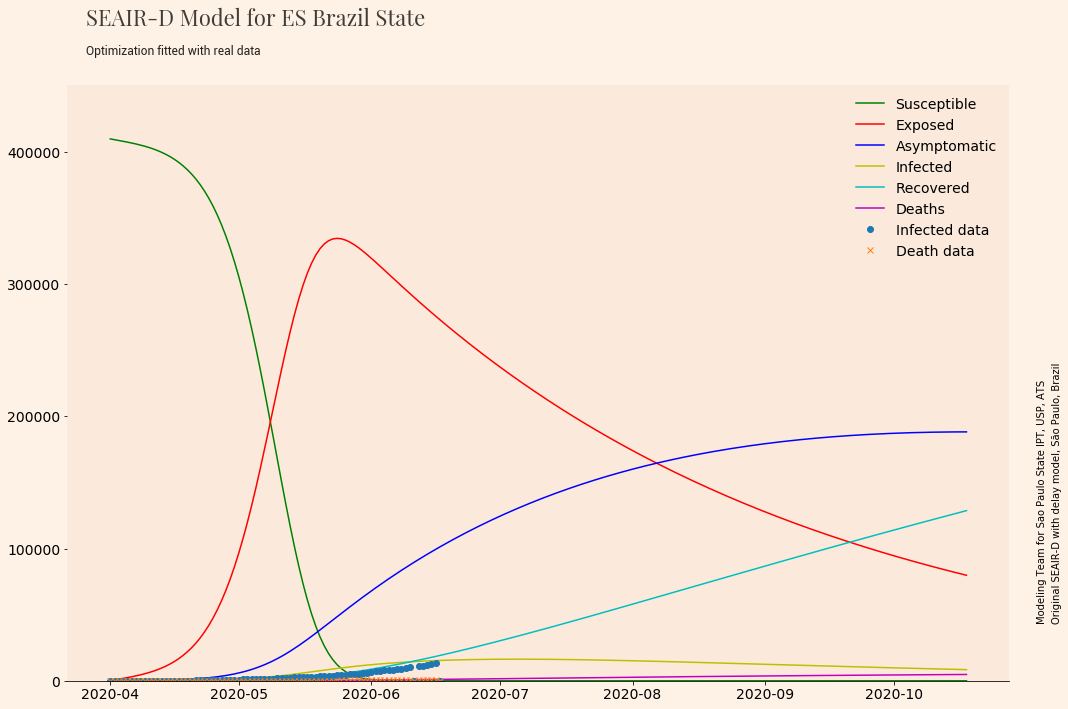

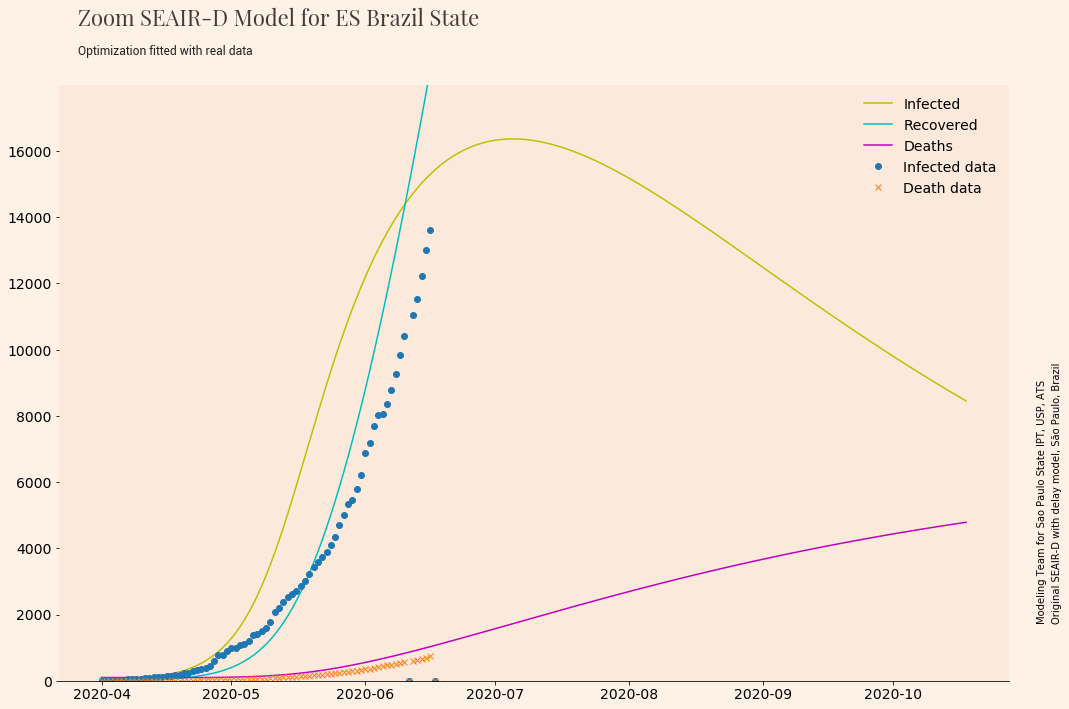

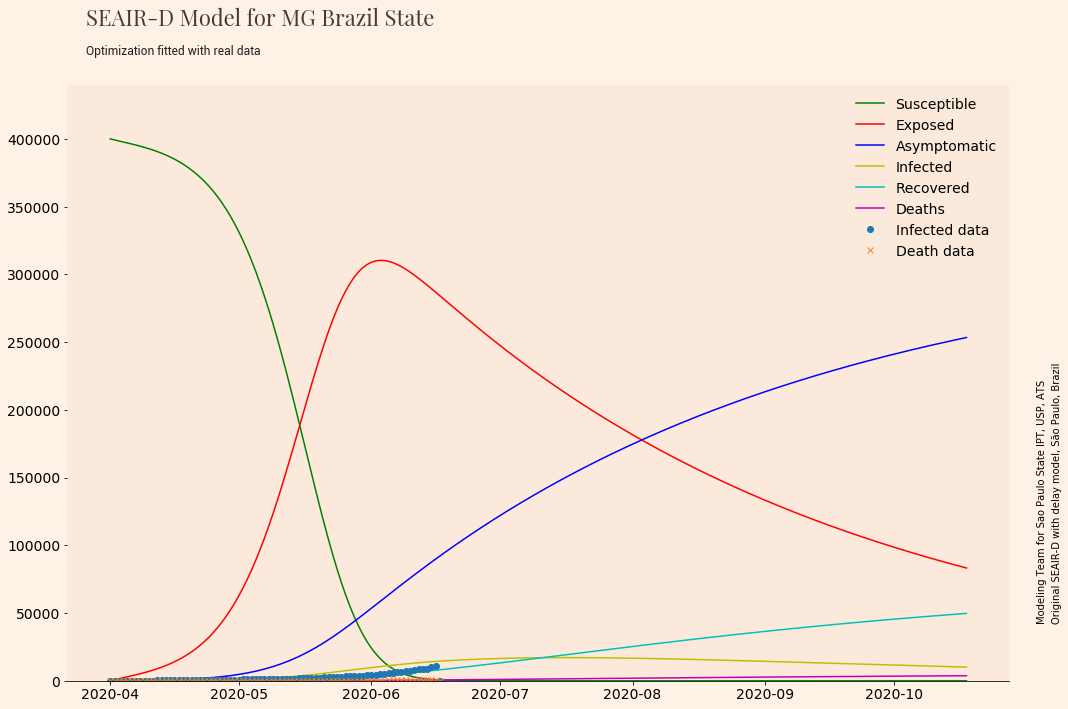

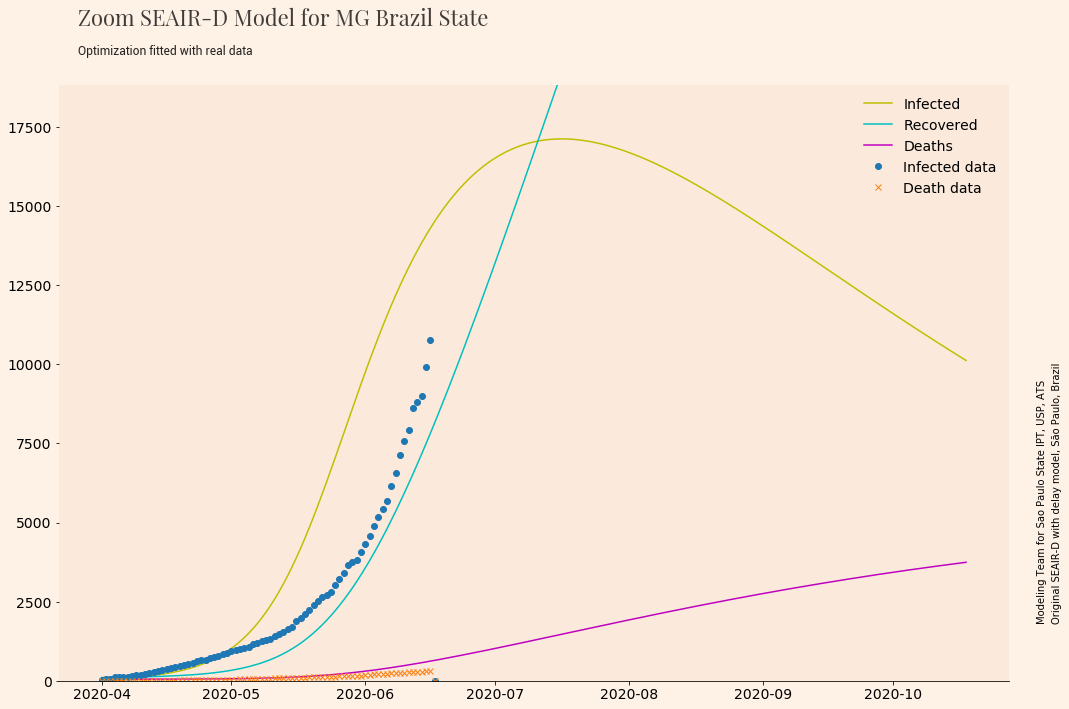

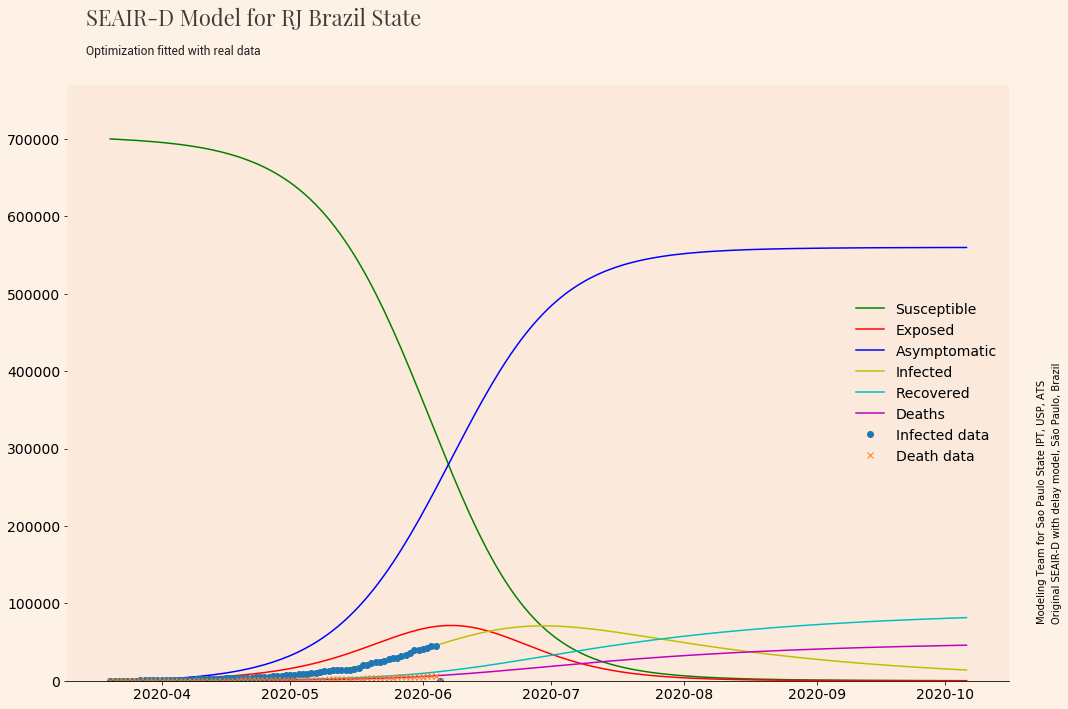

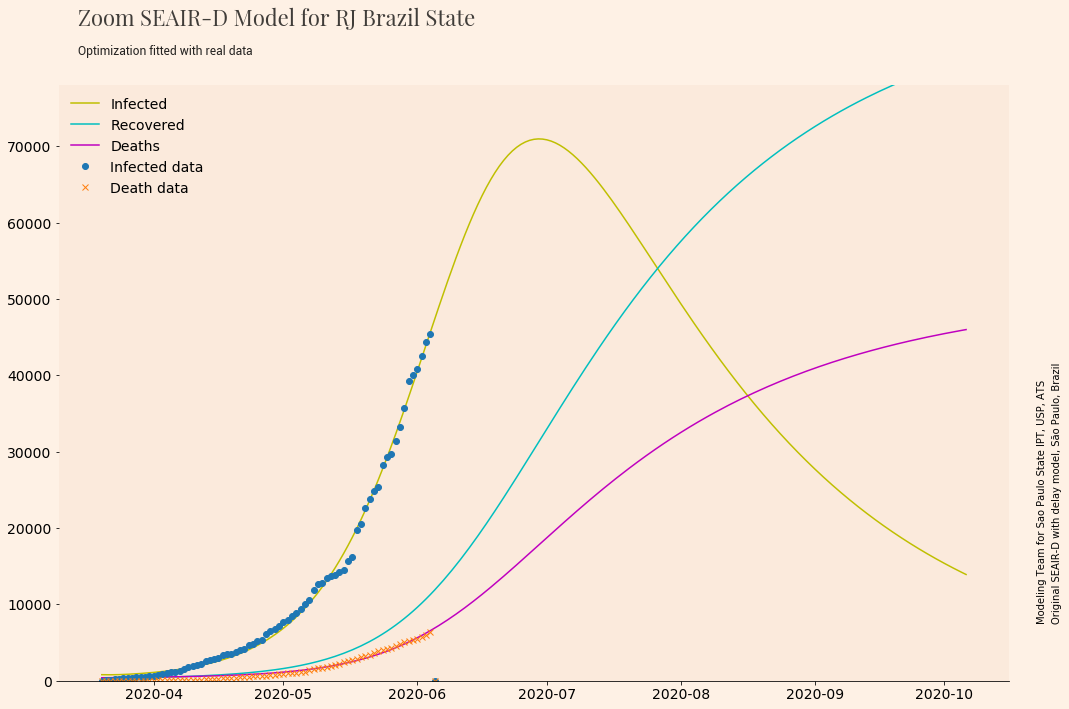

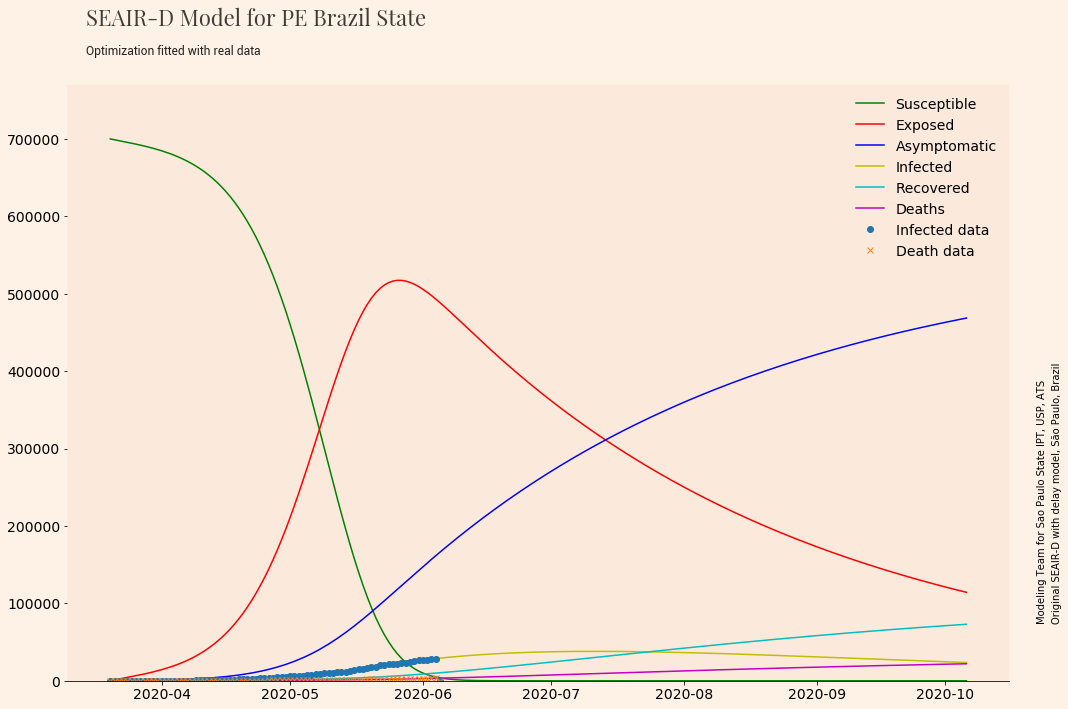

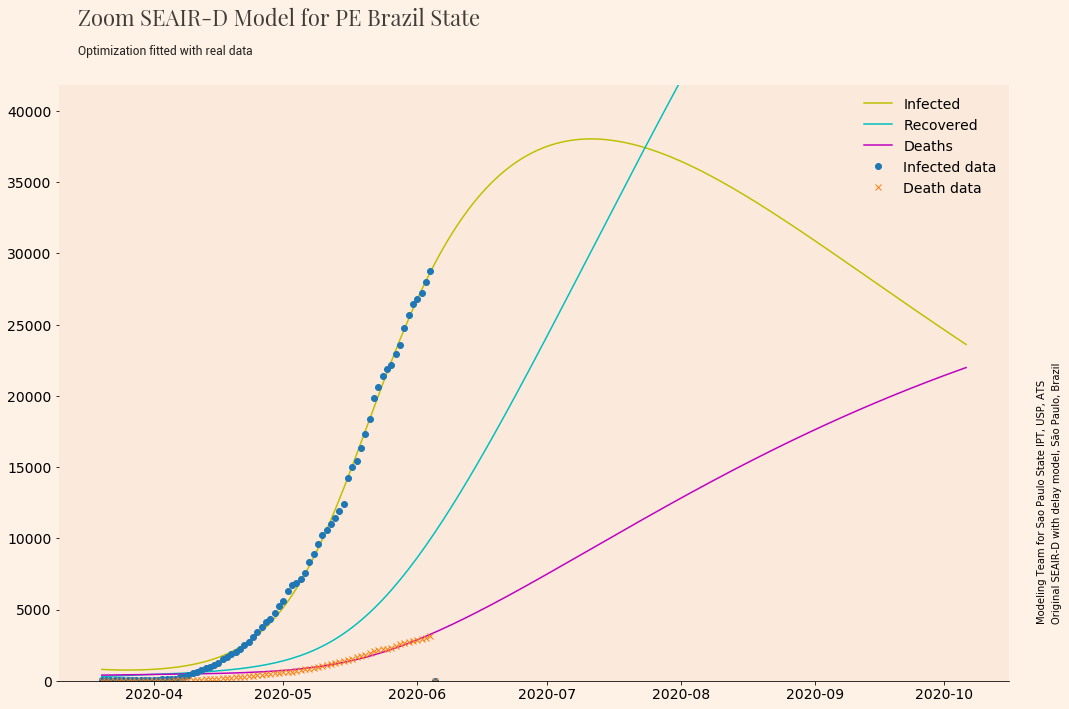

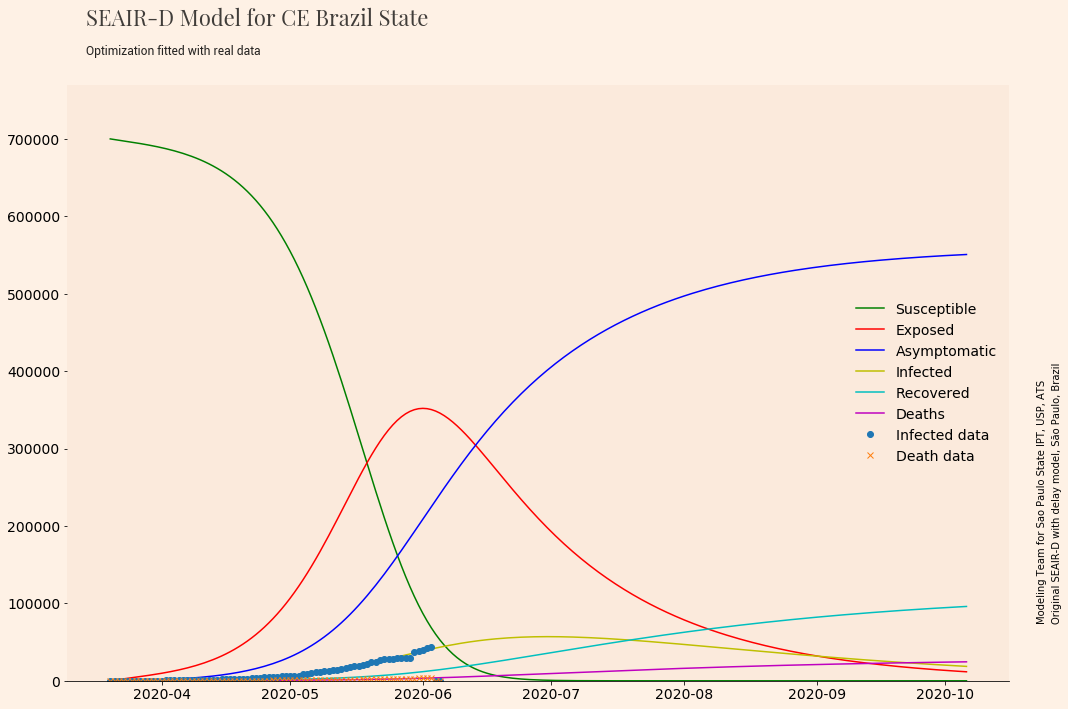

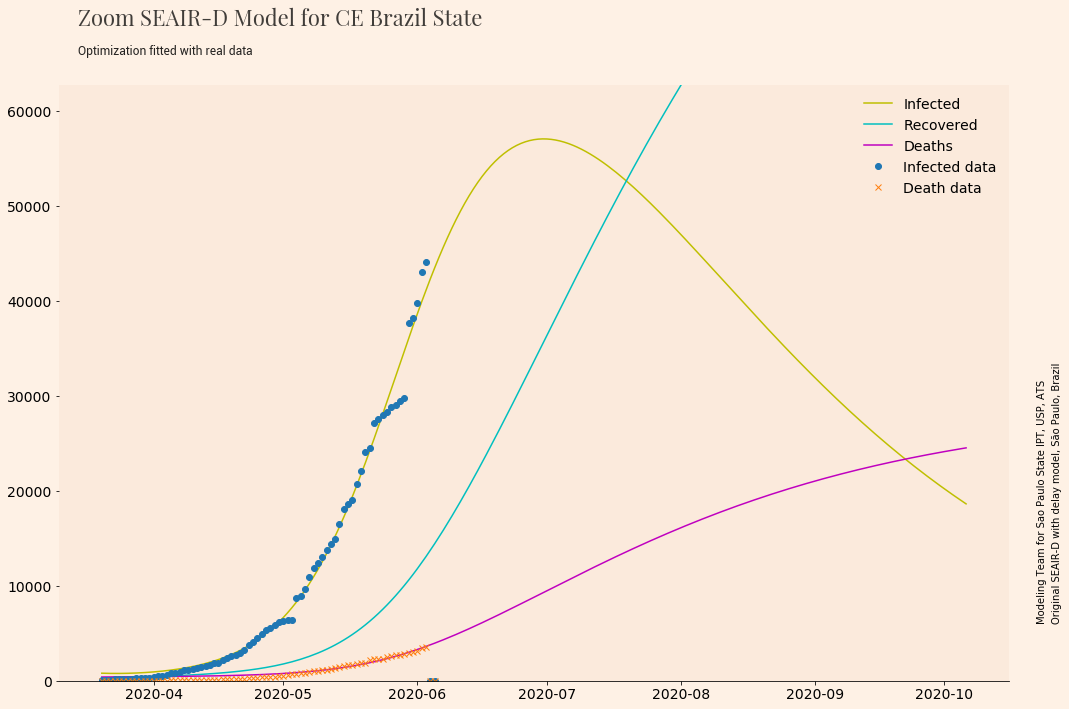

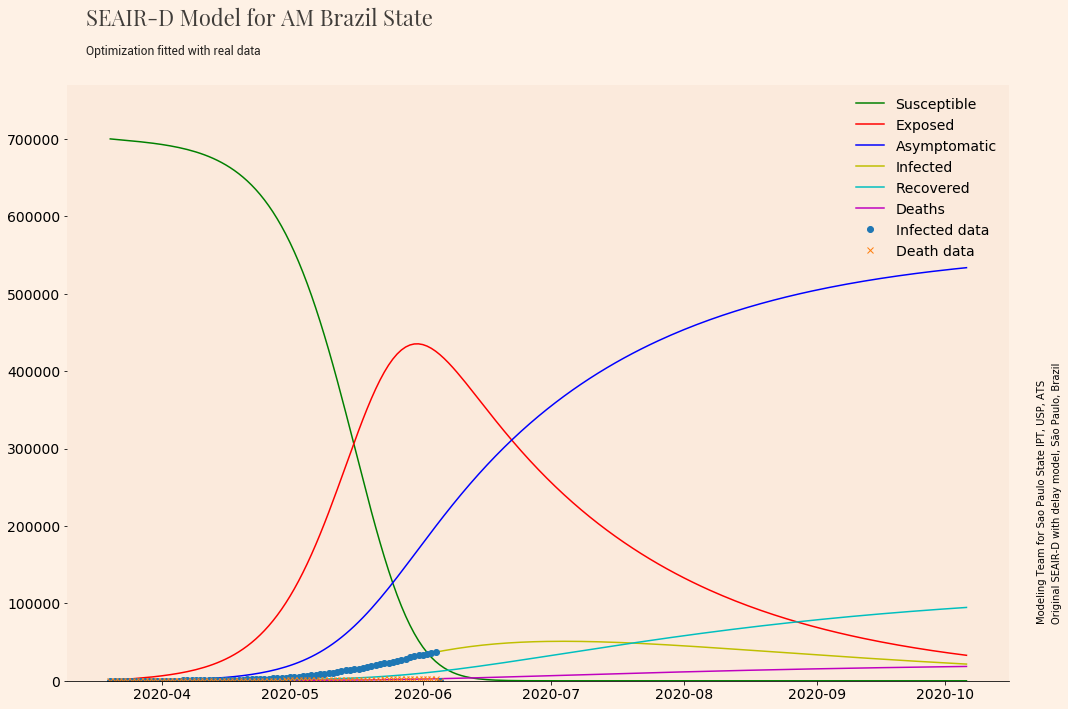

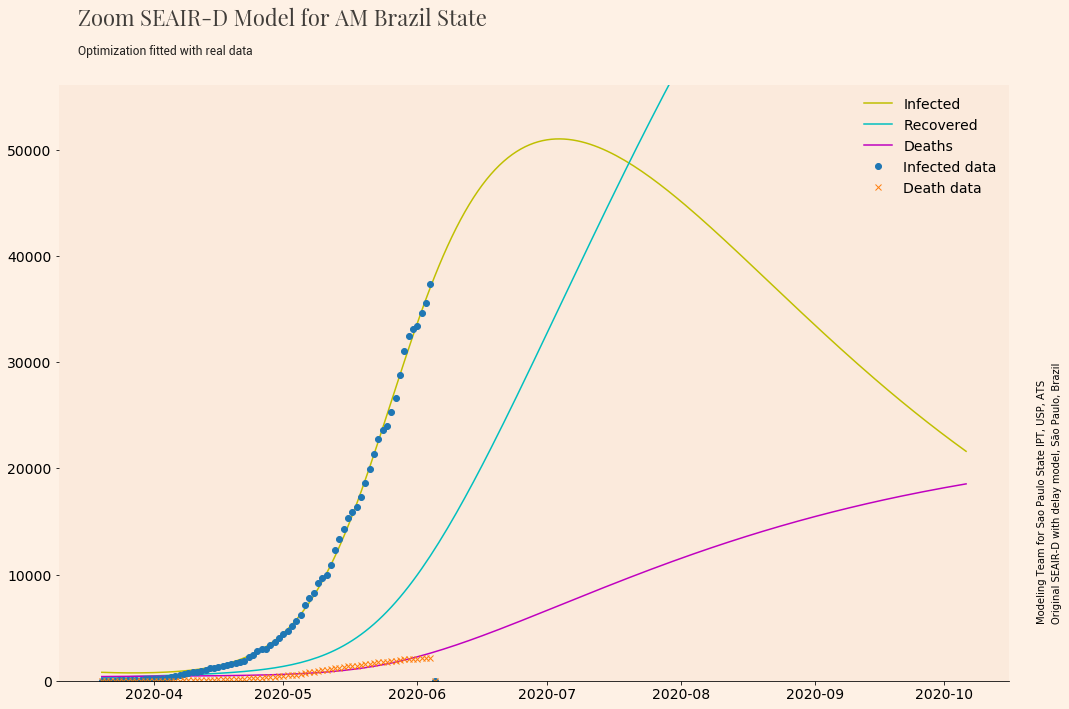

In [16]:
#plots one district or all districts

plotStates=True

if plotStates:
    states=['SP','ES','MG','RJ','PE','CE','AM']
    allStates=True

if allStates:
    for state in states:
        covid_plots.covid_plots(state, states4Plot, startdate,predict_range, \
                                startCase, 5, version, show=True, ratio=ratio)
else: 
    covid_plots.covid_plots(state, states4Plot, startdate,predict_range, \
                                startCase, opt, version, show=True, ratio=ratio)